# **PROYEK PRA UTS PROYEK SAIN DATA**
## **DOKUMENTASI PROSES PEMBUATAN WORKFLOW**

## **Tahap Koneksi ke Database**

- Pilih menu ini

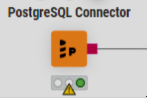


- Lalu akan masuk ke menu tampilan seperti ini dan lakukan konfigurasi

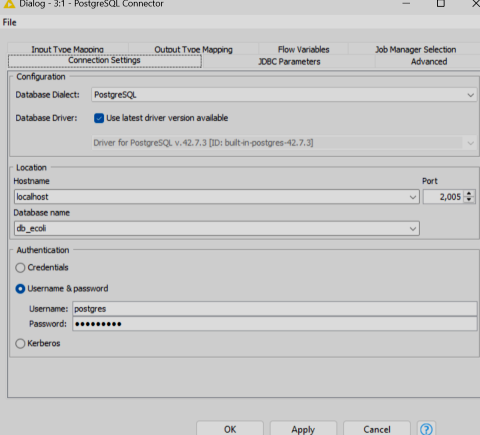

Langkah pertama adalah menghubungkan KNIME Analytics Platform dengan database PostgreSQL yang berisi data penelitian.
Untuk melakukan koneksi digunakan node PostgreSQL Connector, yang berfungsi sebagai jembatan antara KNIME dan database.

Konfigurasi koneksi:

- Host: localhost

- Database: db_ecoli

- Port: 2005

- Username: postgres

- Password: muniiff26

Node ini memastikan bahwa KNIME dapat mengakses data yang tersimpan di dalam database PostgreSQL secara langsung tanpa perlu ekspor manual.
Apabila konfigurasi berhasil, maka akan muncul status “connected” pada node tersebut.

## **Pemilihan Tabel Database**

- Pilih menu ini

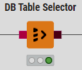


- Lalu akan masuk ke menu tampilan seperti ini

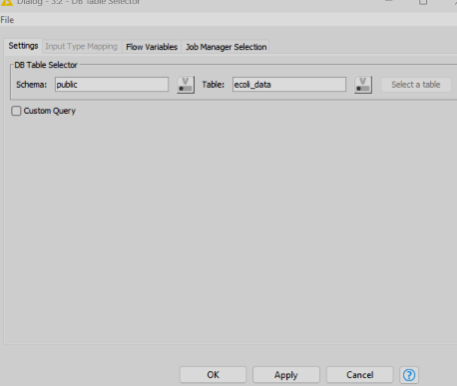


Setelah koneksi berhasil, tahap berikutnya adalah menentukan tabel yang akan digunakan untuk analisis.
Hal ini dilakukan menggunakan node DB Table Selector, yang berfungsi memilih tabel tertentu dari database yang sudah terhubung.

Pengaturan:

- Schema: public

- Table: ecoli_data

Dengan konfigurasi tersebut, node ini mengambil tabel ecoli_data dari schema publik database PostgreSQL.
Tabel inilah yang akan menjadi sumber utama data dalam proses analisis berikutnya.

## **Membaca Data dari Database**

- Pilih menu ini

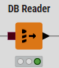



Node ini berperan untuk mengekstrak data dari database ke dalam workflow KNIME.
Data yang sebelumnya hanya berada di sistem database kini ditransformasikan ke dalam bentuk tabel internal KNIME sehingga dapat diolah menggunakan node analisis lainnya.

Tahap ini juga membantu dalam memastikan bahwa struktur data (kolom, tipe data, dan isi) sudah terbaca dengan benar oleh sistem KNIME sebelum melanjutkan ke tahapan pra-pemrosesan.

## **Pemeriksaan dan Penyaringan Missing Value**

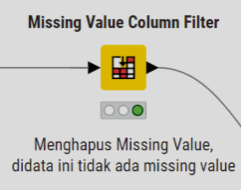

Pada tahap ini digunakan node Missing Value Filter yang berfungsi untuk mendeteksi keberadaan nilai kosong (missing value) pada dataset.
Langkah ini penting untuk menjaga kualitas data karena keberadaan nilai kosong dapat mempengaruhi hasil analisis atau model.

Setelah dilakukan proses pemeriksaan terhadap data ecoli_data, diperoleh hasil bahwa seluruh atribut memiliki nilai lengkap dan tidak ditemukan adanya missing value.
Oleh karena itu, proses pembersihan data pada tahap ini tidak diperlukan dan dapat langsung dilanjutkan ke tahap berikutnya.

## **Deteksi Data Outlier Menggunakan Metode ABOD**

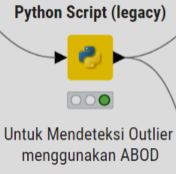


Setelah memastikan data bersih, langkah berikutnya adalah mendeteksi keberadaan outlier (data pencilan) menggunakan metode Angle-Based Outlier Detection (ABOD).
Tahapan ini dilakukan melalui node Python Script, yang memanfaatkan pustaka PyCaret untuk analisis anomali.

In [ ]:
from pycaret.anomaly import *

table = input_table_1.copy()

feature_numeric = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]
feature_non_numeric = ["id", "name", "class"]

s = setup(data=table[feature_numeric])
abod_model = create_model("abod", fraction=0.05)
df_abod = assign_model(abod_model)

output_table_1 = df_abod.merge(table[feature_non_numeric], left_index=True, right_index=True)

**Penjelasan:**

setup() digunakan untuk menginisialisasi lingkungan kerja PyCaret dengan data numerik yang relevan.

create_model("abod", fraction=0.05) membuat model deteksi outlier menggunakan algoritma ABOD, di mana sekitar 5% data dianggap sebagai pencilan.

assign_model() menambahkan label hasil deteksi pada data, dengan nilai:

0 → data normal

1 → data outlier

Proses merge dilakukan agar hasil deteksi digabungkan kembali dengan kolom non-numerik seperti id, name, dan class.

Hasil akhirnya berupa tabel yang telah memiliki kolom tambahan “Anomaly” sebagai indikator data normal atau pencilan.

## **Visualisasi Hasil Deteksi Outlier**


- Plotting data outlier

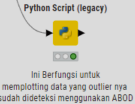


Tahapan ini bertujuan untuk memvisualisasikan posisi data outlier dan data normal agar lebih mudah dianalisis.
Visualisasi dilakukan menggunakan metode Principal Component Analysis (PCA) untuk mereduksi dimensi data numerik menjadi dua komponen utama.

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

ecoli_df = input_table_1.copy()
fitur = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]

pca = PCA(n_components=2)
reduced = pd.DataFrame(pca.fit_transform(ecoli_df[fitur])).reset_index(drop=True)
ecoli_df = ecoli_df.reset_index(drop=True)

reduced = reduced.merge(ecoli_df["Anomaly"], left_index=True, right_index=True)

plt.figure(figsize=(10, 6))
for i in [0, 1]:
    plt.scatter(reduced[reduced["Anomaly"] == i][0], reduced[reduced["Anomaly"] == i][1], label=i)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend(title="Anomaly", bbox_to_anchor=(1.12, 1), loc="upper right")

output_table_1 = reduced
plt.show()


**Penjelasan:**

- PCA menurunkan dimensi data menjadi dua sumbu utama agar data bisa divisualisasikan dalam bentuk 2D.

- Hasil reduksi digabung dengan kolom Anomaly agar tiap titik dapat dibedakan antara data normal (0) dan outlier (1).

- Plot menampilkan dua kelompok data:

- Titik berlabel 0 menunjukkan data normal.

- Titik berlabel 1 menunjukkan data yang terdeteksi sebagai outlier.

- Visualisasi ini memudahkan untuk melihat distribusi dan perbedaan posisi antara data normal dan anomali.

**- Output**

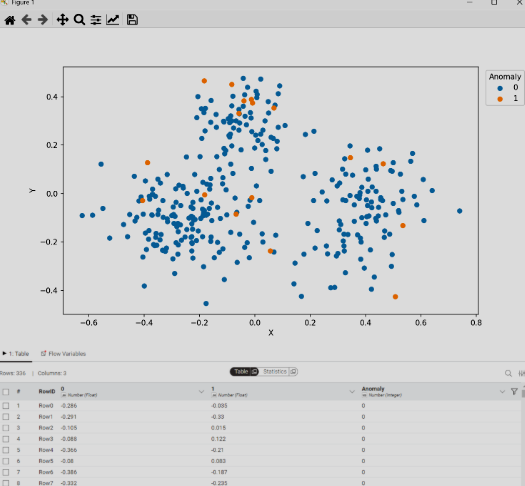

## **Tahap Pembersihan Outlier**

-Pilih menu ini

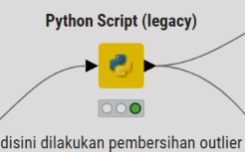

Setelah diketahui data mana yang termasuk outlier, tahap berikutnya adalah menghapus atau menyaring data pencilan dari dataset.
Namun, dalam kasus ini beberapa kelas seperti imL dan imS tetap dipertahankan meskipun mungkin termasuk kategori outlier karena keduanya dianggap penting secara domain data.

In [ ]:
import pandas as pd

ecoli_df = input_table_1.copy()

fitur = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]

ecoli_df = ecoli_df[
    (ecoli_df["Anomaly"] == 0) |
    (ecoli_df["class"] == "imL") |
    (ecoli_df["class"] == "imS")
][["id", "name", "mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2", "class"]]

output_table_1 = ecoli_df

**Penjelasan:**

Data disaring agar hanya menyisakan:

Data normal (Anomaly = 0),

dan dua kelas yang dianggap relevan (imL dan imS).

Baris data selain kondisi tersebut dihapus dari dataset.

Hasil akhirnya adalah data bersih yang siap digunakan untuk proses penyeimbangan (balancing).

**- Output**

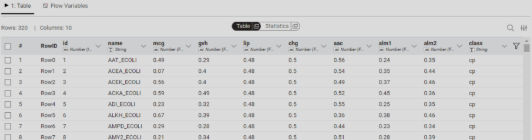

## **Proses Penyeimbangan Data (Data Balancing)**

- Pilih menu ini

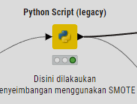

- Distribusi awal kelas

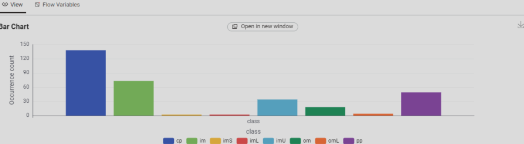

Dataset hasil pembersihan memiliki jumlah data tiap kelas yang tidak seimbang.
Oleh karena itu, dilakukan proses penyeimbangan kelas menggunakan metode SMOTE (Synthetic Minority Oversampling Technique) yang mampu membuat data sintetis untuk kelas dengan jumlah data sedikit.

In [ ]:
ecoli_df = input_table_1.copy()

from imblearn.over_sampling import SMOTE

fitur = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]

p = ecoli_df[fitur]
q = ecoli_df["class"]

p_resampled, q_resampled = SMOTE(random_state=42, k_neighbors=1).fit_resample(p, q)

merge_smote = p_resampled.merge(q_resampled, left_index=True, right_index=True)
output_table_1 = merge_smote

**Penjelasan:**

SMOTE menambah data secara sintetis untuk kelas minoritas dengan memanfaatkan teknik interpolasi antar tetangga terdekat.

Parameter k_neighbors=1 digunakan karena distribusi data per kelas cukup kecil.

Setelah resampling, data numerik dan label kelas digabung kembali menjadi satu tabel (merge_smote).

Hasil akhirnya adalah dataset yang sudah memiliki distribusi kelas yang seimbang, siap digunakan untuk modeling.

## **Distribusi Data Setelah Penyeimbangan**

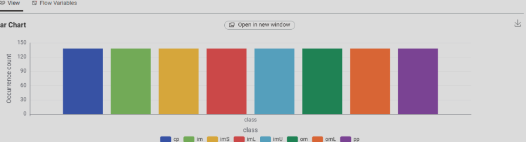

Tahapan terakhir adalah memeriksa kembali distribusi jumlah data setiap kelas setelah dilakukan SMOTE.
Visualisasi distribusi ini menunjukkan bahwa seluruh kelas kini memiliki proporsi data yang hampir sama.

Hal ini menandakan bahwa proses balancing berhasil dan dataset telah siap untuk digunakan pada tahap pemodelan (model training) atau analisis lanjutan.

**- Output**

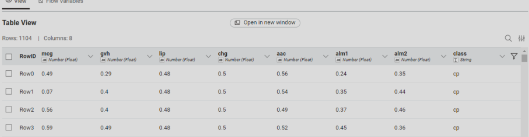

## **Kesimpulan Akhir**

Proses pengerjaan workflow proyek Pra UTS Penambangan Sains Data pada KNIME mencakup seluruh langkah penting dalam tahap preprocessing data, meliputi:

Menghubungkan KNIME dengan database PostgreSQL.

Mengambil tabel ecoli_data sebagai sumber dataset.

Membaca data ke dalam workflow KNIME.

Memastikan tidak ada missing value.

Mendeteksi outlier menggunakan metode ABOD.

Melakukan visualisasi distribusi outlier.

Membersihkan data pencilan yang tidak relevan.

Melakukan balancing data menggunakan metode SMOTE.

Hasil akhir dari seluruh proses ini adalah dataset bersih, bebas outlier, dan seimbang, yang siap digunakan untuk tahapan analisis atau pembangunan model klasifikasi dan clustering selanjutnya.